In [ ]:
# Import librerie necessarie
from timeit import default_timer as timer
from sklearn.preprocessing import StandardScaler, LabelEncoder,
from sklearn.model_selection import train_test_split, cross_val_score,  StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scikeras.wrappers import KerasClassifier

In [2]:
# In questo metodo verifico la dimensione del dataset, la codifica caratteri nel file system ed infine definisco
# il DATAFRAME principale grezzo (raw) 

In [6]:
import os
import chardet #libreria per il detect del charset file
import pandas as pd #lettura file e gestione DF

In [7]:
def put_csv_to_df(file_path):
    # valore della dimensioni del file
    n_bytes = os.path.getsize(file_path)

    print(" - file:", file_path)
    print(" - dimensione del file in Kilobytes:", round(n_bytes/1024, 2))

    # definizione del df principale.
    try:
        rawdata = open(file_path, 'rb').read(n_bytes)

        # Viene determinare la codifica del file
        result = chardet.detect(rawdata)
        encoding = result['encoding']
        
        print(" - La codifica del file è:", encoding)
        
        # Leggi il file CSV utilizzando la codifica determinata
        df = pd.read_csv(file_path, encoding=encoding) 
    except NameError:
        # Se Non è stato rilevato il coding prosegui con lo standard
        df = pd.read_csv(file_path) 
    return df

In [8]:
#Funzioni di Preprocessing:

# Funzione per assegnare 1 se la stringa "descrizione" è presente, altrimenti 0
def assegna_valore_a_descrizione(riga, descrizione):
    if descrizione in riga:
        return 1
    else:
        return 0

# Funzione utilizzata su 'Product type' per traslare la classe di prodotto da testuale 
def assegna_valore_a_descrizioni(riga, array_descrizioni):
    for posizione, prodotto in enumerate(array_descrizioni):
        if prodotto in riga:
            return posizione
    return -1

In [9]:
import numpy as np #lib matamatica
import matplotlib.pyplot as plt #plot dati
import seaborn as sns #lib per il grafico della scattermatrix

In [10]:
# Crea un grafico della matrice di correlazione con la libreria Seaborn 
def plot_correlation_matrix(df_numerico): 
    sns_correlation_matrix = df_numerico.corr()
    plt.figure(figsize=(10, 10))
    
    #sns.heatmap() è utilizzato per creare il grafico della matrice di correlazione. 
    sns_ax = sns.heatmap(sns_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')

    # Ruota le etichette dell'asse x per una migliore visualizzazione
    sns_ax.set_xticklabels(sns_ax.get_xticklabels(), rotation=90, ha='center')

    # Ruota le etichette dell'asse y
    sns_ax.set_yticklabels(sns_ax.get_yticklabels(), rotation=0, ha='right')

    plt.show()
    return sns_correlation_matrix

In [11]:
# Crea una lista ordinata con coppie di features dove la correlazione è maggiore di una soglia specifica 
# (escludendo gli elementi sulla diagonale creando una maschera con np.true poiché la diagonale è sempre 1)
def coppie_correlazione_ordinate_intervallo(sns_correlation_matrix, limite_inf, limite_sup):
    coppie_sns = sns_correlation_matrix.where(np.triu(np.ones(sns_correlation_matrix.shape), k=1).astype(bool))
    coppie_sns_correl_filtr = coppie_sns.stack()
    coppie_sns_correl_filtr = coppie_sns_correl_filtr[(coppie_sns_correl_filtr >= limite_inf) & 
                                                      (coppie_sns_correl_filtr < limite_sup)]

    # Numero di coppie di correlazione che sono comprese nell'intervallo specificato
    numero_coppie_correlazione_alta = coppie_sns_correl_filtr.count()
    print("Numero di coppie di feature con correlazione tra {} e {}: {}".format(
        limite_inf, limite_sup, numero_coppie_correlazione_alta))

    # Nuovo dataframe con le coppie di feature con una correlazione 
    coppie_correl_df = coppie_sns_correl_filtr.reset_index()
    coppie_correl_df.columns = ['Feature_A', 'Feature_B', 'Correlation']

    # Ordina il DataFrame in base alla colonna 'Correlation'
    coppie_correlazione_ordinate = coppie_correl_df.sort_values(by='Correlation', ascending=False)

    return coppie_correlazione_ordinate

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [13]:
# Metodo per l'applicazione dell'OVERSAMPLING per il bilanciamento delle classi ("pass" e "fail")
def oversampling(x, y):
    smote = SMOTE(random_state=42)
    x_resemple, y_resemple = smote.fit_resample(x, y)
    y_resemple = y_resemple.reshape(-1, 1)

    print(" - Numero di risultati con OVERSAMPLING x:", len(x_resemple))
    print(" - Numero di risultati con OVERSAMPLING y:", len(y_resemple))

    check_mask_class_1 = (y_resemple == 1)  
    check_mask_class_0 = (y_resemple == 0) 
    print(" - Numero di risultati con ispezione 'pass':", (check_mask_class_1).sum())
    print(" - Numero di risultati con ispezione 'fail':", (check_mask_class_0).sum())
    return x_resemple, y_resemple

In [14]:
# Metodo per l'applicazione del DOWNSAMPLING   
def downsampling(x, y):
    rus = RandomUnderSampler(random_state=42)
    x_res, y_res = rus.fit_resample(x, y)
    return x_res, y_res

In [15]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [16]:
# Crea il grafico per l'analisi dell'accuratezza tramite la "loss" del modello realizzata durante l'addestramento
def plot_loss_accuracy(loss_per_epoch, acc_per_epoch):
    # Calcolo della media
    loss_per_epoch /= n_splits
    acc_per_epoch /= n_splits

    # Generazione dei grafici
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_per_epoch, label='Loss')
    plt.title('Avg Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc_per_epoch, label='Accuracy')
    plt.title('Avg Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [17]:
# Crea il grafico con la curva ROC
def plot_roc_auc(y_test, predictions):
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds, roc_auc

In [18]:
# Crea il grafico della matriche di confusione
def plot_confusion_matrix(y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel('True Values')
    plt.xlabel('Predict Values')
    plt.show()
    return cm

In [34]:
# Crea un grafico per il confronto tra test e predizioni
def plot_test_vs_predictions(all_y_test, all_predictions):
    all_predictions_rounded = np.round(all_predictions).flatten()

    plt.figure(figsize=(10, 6))
    plt.plot(all_y_test, label='Valori Reali', color='blue', marker='o', linestyle='None', markersize=6)
    plt.plot(all_predictions_rounded, label='Previsioni', color='red', marker='x', linestyle='None', markersize=6)
    plt.title('Confronto tra Valori Reali e Previsioni')
    plt.xlabel('Campioni')
    plt.ylabel('Valori')
    plt.legend()
    plt.show()

In [19]:
# Classificatore basato su un modello sequenziale di keras, i layer di questa rete saranno di 5 unità (1 meno il numero delle feature di input)
# aggiungeremo i layer dense, il layer finae avrà una solo unità, visto che dovrà determinare un valore tra 0 e uno con la funzione di attivazione sigmoide


In [20]:
    from keras.models import clone_model
    from keras.initializers import GlorotUniform
    from keras.optimizers import Adam, RMSprop, SGD
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from sklearn.model_selection import StratifiedKFold
    from timeit import default_timer as timer

2024-02-07 13:03:49.204946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# DEFINIZIONE ARCHITETTURA DEL MODELLO 
# "create_model" definisce un modello predittivo in Keras
def create_model(optimizer=None):
    model = Sequential()
    # layer di input
    model.add(Dense(units=5, activation='relu', input_shape=(x.shape[1],), 
                    kernel_initializer=GlorotUniform(seed=42)))
    # layer nascosto
    model.add(Dense(units=10, activation='relu', kernel_initializer=GlorotUniform(seed=42)))
    # output della rete
    model.add(Dense(units=1, use_bias=False, activation='sigmoid', kernel_initializer=GlorotUniform(seed=42)))

    if optimizer is not None:
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
    return model

In [22]:
# "reset_weights " fornisce una funzione per il reset dei parametri 
def reset_weights(model):
    """reset model weights """
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            # Ottieni l'inizializzatore per i pesi del kernel (layer)
            initializer = layer.kernel_initializer
            new_kernel = initializer(shape=layer.kernel.shape)
            # Ottieni eventuali bias e reinizializzali, se il layer ne ha
            if hasattr(layer, 'bias') and layer.bias is not None:
                bias_initializer = layer.bias_initializer
                new_bias = bias_initializer(shape=layer.bias.shape)
                layer.set_weights([new_kernel, new_bias])
            else:
                layer.set_weights([new_kernel])

In [23]:
# ................................................................

In [24]:
# CONFIGURAZIONE DEL PROGETTO E CREAZIONE DEL DF
current_directory = os.getcwd()

file_path = current_directory + '/data/supply_chain_data.csv'

# definizione del dataframe 
df = put_csv_to_df(file_path)

 - file: /home/cristiano/Developer/Python/Tesi/Kaggle/datasets/harshsingh2209/data/supply_chain_data.csv
 - dimensione del file in Kilobytes: 20.56
 - La codifica del file è: ascii


In [25]:
df.head()

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


In [26]:
# PREPROCESSING: 
# QUESTA FASE E' DEDICATA A QUESTO DATASET SPECIFICO BASANDOSI SULLE PROPRIETA SUE DELLE COLONNE

In [27]:
# convertendo le etichette dei risultati dei test in classi di valori numerici
df['Inspection passed'] = df['Inspection results'].apply(lambda x: assegna_valore_a_descrizione(x, 'Pass'))    
df['Inspection failed'] = df['Inspection results'].apply(lambda x: assegna_valore_a_descrizione(x, 'Fail')) 
df['Inspection unknow'] = df['Inspection results'].apply(lambda x: assegna_valore_a_descrizione(x, 'Pending'))

# Convetiamo in nomi dei prodotti in classi di valore numerico
array_prodotti = ['haircare', 'skincare', 'cosmetics']
df['Product class'] = df['Product type'].apply(lambda x: assegna_valore_a_descrizioni(x, array_prodotti))

# TODO: 
#   Come per "Inspection results" potremo rimappare i valori testuali in numerici o classi anche per le altre 
#   colonne se queste fossero significative per incrementare il valore informativo del dataset
#   ad esempio: potremo usare il labelEncoder, per le colonne 'Product type', "SKU", "Customer demographics", 
# "Transportation modes" o "Routes"
# label_encoder_sex = LabelEncoder()
# x[:,7] = label_encoder_sex.fit_transform(x[:,7])
#

In [28]:
# Verifica dei dati congrui in un nuovo dataframe
verification_mask = ((df['Inspection passed'] != df['Inspection failed']) & (df['Inspection unknow'] == 0))
df_filtered = df[verification_mask].copy()

# verifica dei casi filtrati rispetto ai totali originali
numero_totale = len(df)
numero_filtered = len(df_filtered)
print(" - Numero risultati totali:", numero_totale)
print(" - Numero risultati filtrati:", numero_filtered)

# verifica dei risultati classificati
check_pass_mask = (df_filtered['Inspection passed'] == 1) 
check_fail_mask = (df_filtered['Inspection failed'] == 1) 
print(" - Numero di risultati con ispezione 'passata':", (check_pass_mask).sum())
print(" - Numero di risultati con ispezione 'fallita':", (check_fail_mask).sum())

# elimino dal DF la colonna "stato sconosciuto"
df_filtered.drop('Inspection unknow', axis=1, inplace=True) 

# filtriamo ulteriormente escludendo dati non non numerici in un nuovo dataframe numerico
df_numerico = df_filtered.select_dtypes(include=['number'])

# verifica presenza di campi nulli nel dataframe
print(" - presenza di campi nulli nel dataframe numerico:", df_numerico.isnull().values.any())

 - Numero risultati totali: 100
 - Numero risultati filtrati: 59
 - Numero di risultati con ispezione 'passata': 23
 - Numero di risultati con ispezione 'fallita': 36
 - presenza di campi nulli nel dataframe numerico: False


In [29]:
# veclassca sul risultato, mi aspetto ora che le seguenti verifiche non riportino nessun caso
check_mask_twist = (df_filtered['Inspection passed'] == df_filtered['Inspection failed'])
#check_mask_doubt = ((df_filtered['Inspection unknow'] == 1) & ((df_filtered['Inspection passed'] == 1) | (df_filtered['Inspection failed'] == 1)))

print(" - Numero di risultati falsati:", (check_mask_twist).sum())
#print(" - Numero di risultati incerti:", (check_mask_doubt).sum())

# Effettuo un verifica visuale dei dati ottenuti
df_numerico.head()


 - Numero di risultati falsati: 0


,Price,Availability,Number of products sold,Revenue generated,Stock levels,Lead times,Order quantities,Shipping times,Shipping costs,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Defect rates,Costs,Inspection passed,Inspection failed,Product class
3,61.163343,68,83,7766.836426,23,13,59,6,1.729569,24,937,18,35.624741,4.746649,254.776159,0,1,1
4,4.805496,26,871,2686.505152,5,3,56,8,3.890548,5,414,3,92.065161,3.145580,923.440632,0,1,1
5,1.699976,87,147,2828.348746,90,27,66,3,4.444099,10,104,17,56.766476,2.779194,235.461237,0,1,0
7,42.958384,59,426,8496.103813,93,17,11,1,2.348339,22,564,1,99.466109,0.398177,802.056312,0,1,2
10,15.707796,11,996,2330.965802,51,13,80,2,8.673211,18,830,5,96.527353,1.727314,806.103178,1,0,1


In [30]:
# FEATURING ENG.
# Una volta ripuliti i dati il passo successivo è quello di individuare le correlazioni per fare ipotesi 
# su come incrementare l'utilità dei dati 
# escludendo dati non pertinenti,

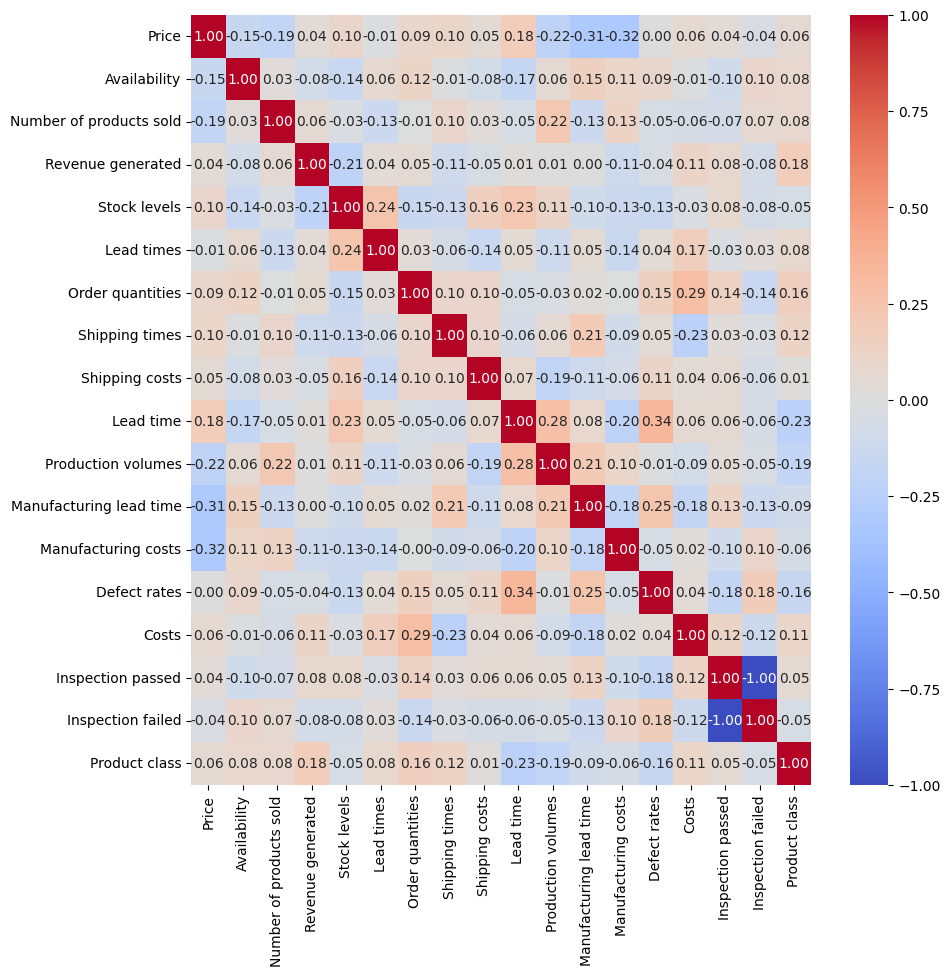

Numero di coppie di feature con correlazione tra 0.15 e 0.95: 17
Coppie di feature ordinate con correlazione tra 0.15 e 0.95:
                  Feature_A                Feature_B  Correlation
13                Lead time             Defect rates     0.343486
9          Order quantities                    Costs     0.290781
12                Lead time       Production volumes     0.280315
15  Manufacturing lead time             Defect rates     0.248304
4              Stock levels               Lead times     0.244470
6              Stock levels                Lead time     0.232624
2   Number of products sold       Production volumes     0.222321
14       Production volumes  Manufacturing lead time     0.214041
11           Shipping times  Manufacturing lead time     0.207810
3         Revenue generated            Product class     0.184127
0                     Price                Lead time     0.181071
16             Defect rates        Inspection failed     0.176459
7               

In [32]:
# Plot della matrice di correlazione per le features
sns_correlation_matrix = plot_correlation_matrix(df_numerico)

limite_inf = 0.15
limite_sup = 0.95

# Elenco tutte le coppie con una correlazione compresa tra i limiti inf. e sup.
coppie_correlazione_ordinate = coppie_correlazione_ordinate_intervallo(
    sns_correlation_matrix, limite_inf, limite_sup)

# Stampa le coppie ordinate di feature correlate
print("Coppie di feature ordinate con correlazione tra {} e {}:".format(limite_inf, limite_sup))
print(coppie_correlazione_ordinate) 

In [37]:
# DEFINIZIONE DELLE FEATURE DEL MODELLO 
# Elenco tutte le colonne delle features X con un alto indice di correlazione
lead_time_idx = df_numerico.columns.get_loc("Lead time")
defect_rates_idx = df_numerico.columns.get_loc("Defect rates") 
order_quantities_idx = df_numerico.columns.get_loc("Order quantities")  
production_valumes_idx = df_numerico.columns.get_loc("Production volumes") 
manufacturing_lead_time_idx = df_numerico.columns.get_loc("Manufacturing lead time") 
stock_levels_idx = df_numerico.columns.get_loc('Stock levels')

x = df_numerico.iloc[:, [manufacturing_lead_time_idx, 
                         lead_time_idx, 
                         production_valumes_idx,  
                         defect_rates_idx, 
                         stock_levels_idx, 
                         order_quantities_idx, ]].values

# Colonna Y per la classificazione binaria (caso flag negativo: FALLITO = 1)
inspection_failed_idx = df_numerico.columns.get_loc("Inspection failed")

y = df_numerico.iloc[:, [ inspection_failed_idx]].values #classificazione negativa

In [38]:
# Ribilanciamo delle features x e y
x_resemple, y_resemple = oversampling(x, y)

 - Numero di risultati con OVERSAMPLING x: 72
 - Numero di risultati con OVERSAMPLING y: 72
 - Numero di risultati con ispezione 'pass': 36
 - Numero di risultati con ispezione 'fail': 36


In [39]:
from sklearn.preprocessing import MinMaxScaler

In [40]:
# Normalizzazione di x
sc_cv = MinMaxScaler()
sc_cv.fit(x_resemple)
x_norm = sc_cv.transform(x_resemple)

In [41]:
# Definizione degli Iper-parametri per l'addestramento del modello
learning_rate = 0.001
epochs = 40
batch_size = 8
n_splits = 8

# Definizione del modello principale
optimizer = Adam(learning_rate=learning_rate) 
original_model = create_model()
original_model.summary()

def esegui_apprendimento(x, y, model, optimizer, epochs = 40, batch_size = 8, n_splits = 8):
    # Liste per la registrazione dei dati di addestramento  
    loss_per_epoch = []
    acc_per_epoch = []
    cvscores = []
    all_y_test = []
    all_predictions = []

    # Definizione parametri per la cross-validation
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    start = timer()

    # ADDESTRAMENTO DEL MODELLO
    for train, test in kfold.split(x_resemple, y_resemple):
        # Ad ogni iterazione il modello viene clonato dall'originale, ma basato sul fold corrente 
        classifier = clone_model(original_model)
        reset_weights(classifier)

        # Compilazione del modello
        classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        result = classifier.fit(
            x_norm[train], y_resemple[train], epochs=epochs, batch_size=batch_size, verbose=0)

        # Ad ogni iterazione registra i dati di loss e accuracy
        if len(loss_per_epoch) == 0:  # Se è il primo fold
            loss_per_epoch = np.array(result.history['loss'])
            acc_per_epoch = np.array(result.history['accuracy'])
        else:  # Aggiungi i dati medianti
            loss_per_epoch += np.array(result.history['loss'])
            acc_per_epoch += np.array(result.history['accuracy'])

        # Valutazione del modello
        scores = classifier.evaluate(x_norm[test], y_resemple[test], verbose=1)
        cvscores.append(scores[1] * 100)

        # Previsioni per il fold corrente
        predictions = classifier.predict(x_norm[test])
        all_y_test.extend(y_resemple[test])
        all_predictions.extend(predictions)

    end = timer()
    print('Modello creato e addestrato in ', round(end-start, 2), 'secondi');
    return all_y_test, all_predictions, cvscores, loss_per_epoch, acc_per_epoch

all_y_test, all_predictions, cvscores, loss_per_epoch, acc_per_epoch = esegui_apprendimento(
    x = x, y = y, model = original_model, optimizer = optimizer , epochs = 40, batch_size = 8, n_splits = 8)
    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 35        
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dense_2 (Dense)             (None, 1)                 10        
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 46ms/step
Modello creato e addestrato in  11.63 secondi


In [43]:
# Calcolo delle metriche per la VALUTAZIONE DEL MODELLO
# Calcolo della media e della deviazione standard delle accuratezze
print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Accuracy: 68.06% (+/- 12.95%)


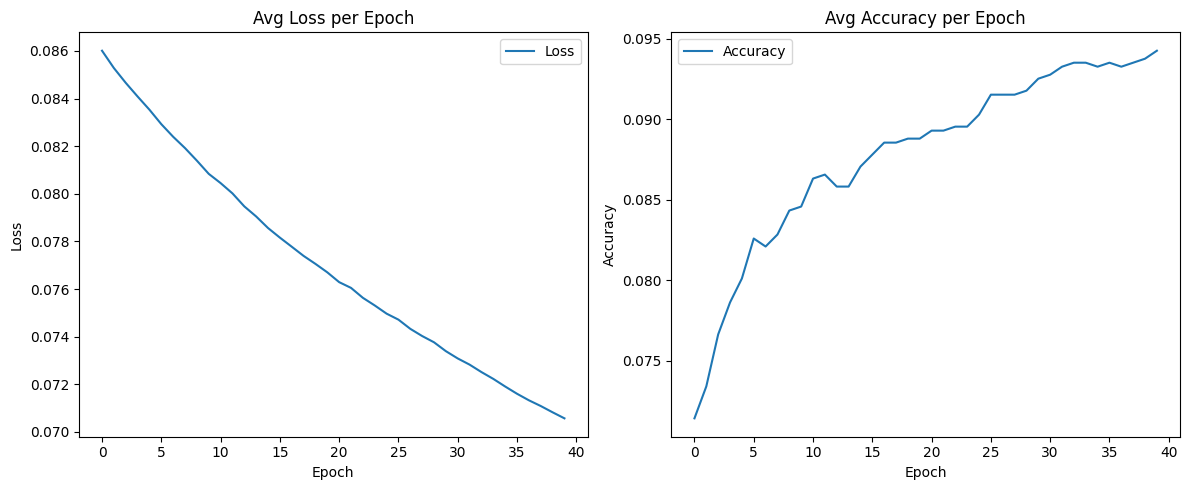

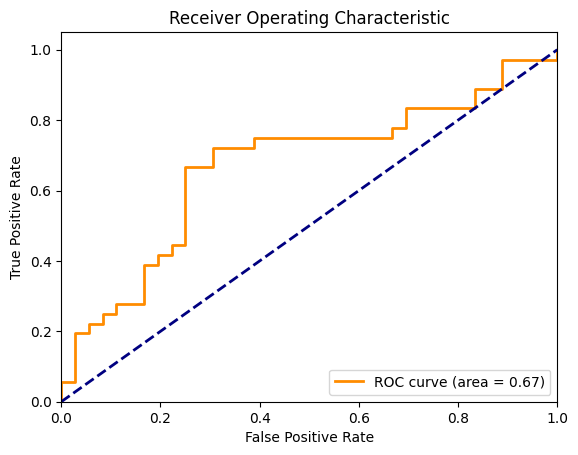

Roc Auc: 0.6705246913580247


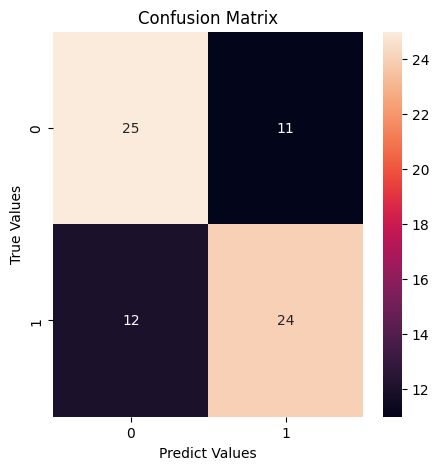

Accuratezza modello (Calcolata): 68.05555555555556 %
Tasso di errore (Calcolata): 31.944444444444443 %


In [46]:
# Plot della funzione di costo (loss)
plot_loss_accuracy(loss_per_epoch, acc_per_epoch)

# Calcolo e plot della ROC curve
fpr, tpr, thresholds, roc_auc = plot_roc_auc(np.array(all_y_test), np.array(all_predictions))

# L'AUC-ROC è una metrica utilizzata per valutare la performance di un modello di classificazione binaria.    
print("Roc Auc:", roc_auc) 

# Calcolo e plot della confusion matrix e calcolo accuratezza
cm = plot_confusion_matrix(np.array(all_y_test), np.array(all_predictions).round())

false_positive = cm[0, 1]
false_negative = cm[1, 0]
true_negative = cm[0, 0]
true_positive = cm[1, 1]

accuracy = (true_positive + true_negative) / cm.sum()
error_rate = 1 - accuracy
print('Accuratezza modello (Calcolata):', accuracy * 100, '%')
print('Tasso di errore (Calcolata):', error_rate * 100, '%')